In [1]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

from custom_trading_env import TradingEnv

from utils import collect_trajectories, device, clipped_surrogate

from PPOTradingAgent.model import CNNTradingAgent
from common.multiprocessing_env import  SubprocVecEnv

from tqdm import tqdm, tnrange


In [2]:
df = pd.read_hdf('dataset/binance_data_train.h5', 'STW')
df.fillna(method='ffill', inplace=True)

In [3]:
# Hyperparameters

class args:
    def __init__(self,no_short):
        self.no_short = no_short
        self.device_num = 0
        self.n_episodes = 3000
        self.risk_aversion  = 1
args = args(True)
device = "cuda:" + str(args.device_num) if torch.cuda.is_available() else "cpu"
save_interval = 1000
num_envs = 16
n_episodes   = args.n_episodes
sample_len   = 480
obs_data_len = 256
step_len     = 16
risk_aversion_multiplier = 0.5 + args.risk_aversion / 2
n_action_intervals = 5
init_budget = 1

In [4]:
def make_env():
    def _thunk():
        env = TradingEnv(custom_args=args, env_id='custom_trading_env', obs_data_len=obs_data_len, step_len=step_len, sample_len=sample_len,
                           df=df, fee=0.001, initial_budget=1, n_action_intervals=n_action_intervals, deal_col_name='c', sell_at_end=True,
                           feature_names=['o', 'h','l','c','v',
                                          'num_trades', 'taker_base_vol'])

        return env

    return _thunk

In [5]:
envs = [make_env() for _ in range(num_envs)]
envs = SubprocVecEnv(envs)

[2019-08-22 21:27:03,464] Making new env: custom_trading_env
[2019-08-22 21:27:03,470] Making new env: custom_trading_env
[2019-08-22 21:27:03,478] Making new env: custom_trading_env
[2019-08-22 21:27:03,486] Making new env: custom_trading_env
[2019-08-22 21:27:03,494] Making new env: custom_trading_env
[2019-08-22 21:27:03,506] Making new env: custom_trading_env
[2019-08-22 21:27:03,500] Making new env: custom_trading_env
[2019-08-22 21:27:03,516] Making new env: custom_trading_env
[2019-08-22 21:27:03,536] Making new env: custom_trading_env
[2019-08-22 21:27:03,529] Making new env: custom_trading_env
[2019-08-22 21:27:03,541] Making new env: custom_trading_env
/home/jeffrey/Binanace_trading_simulation/agent/PPO/custom_trading_env.py:74: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  self.price = self.df_sample[self.price_name].as_matrix()
/home/jeffrey/Binanace_trading_simulation/agent/PPO/custom_trading_env.py:74: FutureWarning: Method .

/home/jeffrey/Binanace_trading_simulation/agent/PPO/custom_trading_env.py:76: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  self.obs_features = self.df_sample[self.using_feature].as_matrix()


In [6]:
model = CNNTradingAgent(num_features=envs.reset().shape[-1], n_actions=2 * n_action_intervals + 1).to(device)

In [7]:
model.load_state_dict(torch.load('saves/Original/1/TradingGym_10000.pth' ,map_location = device))
model.eval()
for param in model.parameters():
    param.requires_grad_(False)

In [8]:
def integrated_gradient(input_data, baseline_data, action, n_steps):
    assert input_data.shape == baseline_data.shape, "the shape of `input_data` and `baseline_data` must match."\
                                                    "(Given shapes: {}, {})".format(input_data.shape, baseline_data.shape)
    
    diff      = input_data.data - baseline_data.data
    increment = diff / n_steps
    
    x = baseline_data.data.clone()
    x.requires_grad_(True)
    
    for i in tnrange(n_steps):
        
        
        q = model(x.unsqueeze(0))[0,action]
        q.backward()
               
        x.data.add_(increment)
    
    x.grad.div_(n_steps)
    
    return (diff * x.grad).squeeze(0)

In [9]:
state = envs.reset()
for _ in tnrange(50):  
        probs = model(torch.from_numpy(state).float().to(device))
        dist = Categorical(probs)
        action = dist.sample()
 
        next_state, reward, done, _ = envs.step(action.cpu().numpy())
        state = next_state
        
        if done.any():
            break

In [10]:
state  = state[-1]

In [11]:
input_data    = torch.from_numpy(state).float().to(device)
baseline_data = torch.zeros_like(input_data).to(device)

In [12]:
input_data.shape

torch.Size([256, 15])

In [13]:
baseline_data.shape

torch.Size([256, 15])

In [14]:
importances = integrated_gradient(input_data,baseline_data,action = 3 , n_steps = 64)

In [20]:
importances_list = [integrated_gradient(input_data, baseline_data, action=act, n_steps=100) for act in tnrange(2*n_action_intervals+1, desc = "action loop")]

## original

[]

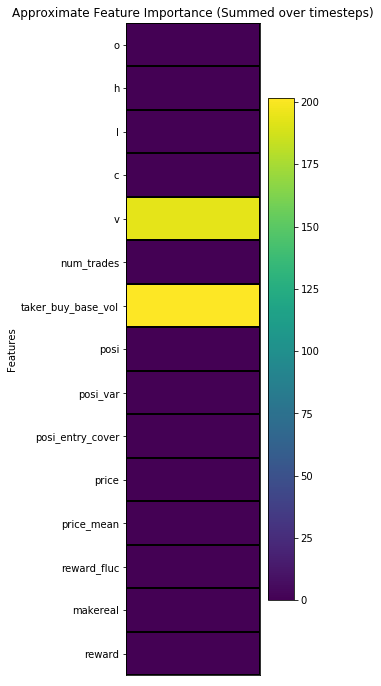

In [18]:
imp_sum = importances.cpu().sum(dim=0, keepdim=True).abs().t().flip([0])

fig, ax = plt.subplots(1, 1, figsize=(3, 12))

img = ax.pcolormesh(imp_sum, cmap='viridis', edgecolors='black')
fig.colorbar(img)

ax.set_title('Approximate Feature Importance (Summed over timesteps)')

ax.set_ylabel('Features')
ax.set_yticks(np.arange(importances.shape[1]) + 0.5)
ax.set_yticklabels(['o', 'h','l','c','v', 'num_trades', 'taker_buy_base_vol',
                    'posi', 'posi_var', 'posi_entry_cover', 'price', 'price_mean',
                    'reward_fluc', 'makereal', 'reward'][::-1])
# plt.setp(ax.get_xticklabels(), rotation=45, ha="left", rotation_mode="anchor")

ax.set_xticks([])

# for i in range(importances.shape[1]):
#     text = ax.text(0.5, i+0.5, '{:f}'.format(imp_sum[i, 0].item()),
#                    ha="center", va="center", color="b",
#                    path_effects=[PathEffects.withStroke(linewidth=5, foreground='w')])

In [21]:
concat = torch.stack(importances_list)
concat.shape

torch.Size([11, 256, 15])

Text(0.5, 0, 'Actions')

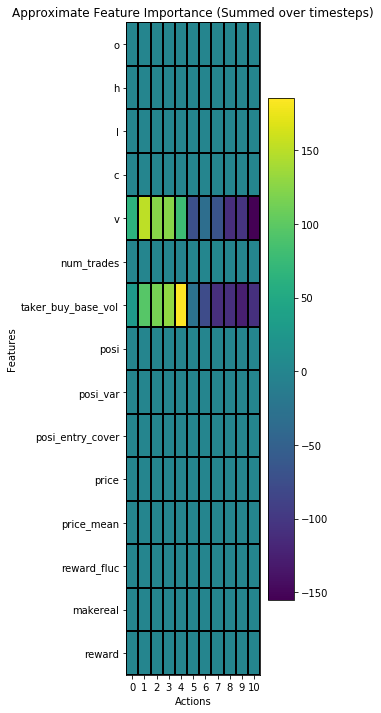

In [23]:
concat_sum = concat.sum(dim= 1)
imp_sum = concat_sum.t().flip([0]).cpu()

fig, ax = plt.subplots(1, 1, figsize=(3, 12))

img = ax.pcolormesh(imp_sum, cmap='viridis', edgecolors='black')
fig.colorbar(img)

ax.set_title('Approximate Feature Importance (Summed over timesteps)')

ax.set_ylabel('Features')
ax.set_yticks(np.arange(importances.shape[1]) + 0.5)
ax.set_yticklabels(['o', 'h','l','c','v', 'num_trades', 'taker_buy_base_vol',
                    'posi', 'posi_var', 'posi_entry_cover', 'price', 'price_mean',
                    'reward_fluc', 'makereal', 'reward'][::-1])
# plt.setp(ax.get_xticklabels(), rotation=45, ha="left", rotation_mode="anchor")
ax.set_xticks(np.arange(11)+0.5)
ax.set_xticklabels(list(map(str,range(11))))
ax.set_xlabel('Actions')
# for i in range(importances.shape[1]):
#     text = ax.text(0.5, i+0.5, '{:f}'.format(imp_sum[i, 0].item()),
#                    ha="center", va="center", color="b",
#                    path_effects=[PathEffects.withStroke(linewidth=5, foreground='w')])